In [1]:
import matplotlib.pyplot as plt
import matplotlib.pylab as plabt
import numpy as np
import os
import PIL
import time
import datetime
import PIL.Image as Image

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive #Only if you are using Google Drive
drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)
%cd /content/gdrive/My\ Drive/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Mounted at /content/gdrive
/content/gdrive/My Drive


In [4]:
train_dir = '/content/gdrive/MyDrive/content/img_dir/train/'
validation_dir = '/content/gdrive/MyDrive/content/img_dir/test/'
data_dir = '/content/gdrive/MyDrive/content/img_dir/all/'

img_height = 224
img_width = 224
batch_size = 32
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Found 8716 files belonging to 10 classes.
Using 6973 files for training.
Found 8716 files belonging to 10 classes.
Using 1743 files for validation.


In [ ]:
#(x_train, y_train), (x_test, y_test)=tf.keras.datasets.mnist.load_data()
#x_train = tf.pad(x_train, [[0, 0], [2,2], [2,2]])/255
#x_test = tf.pad(x_test, [[0, 0], [2,2], [2,2]])/255
#x_train = tf.expand_dims(x_train, axis=3, name=None)
#x_test = tf.expand_dims(x_test, axis=3, name=None)
#x_train = tf.repeat(x_train, 3, axis=3)
#_test = tf.repeat(x_test, 3, axis=3)
#x_val = x_train[-2000:,:,:,:]
#y_val = y_train[-2000:]
##x_train = x_train[:-2000,:,:,:]
#y_train = y_train[:-2000]

In [6]:
base_model = tf.keras.applications.VGG16(weights = 'imagenet', include_top = False, input_shape = (224,224,3))
for layer in base_model.layers:
  layer.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
#eature_extractor_model = tf.keras.applications.VGG16(weights = 'imagenet', include_top = False, input_shape = (224,224,3))
##for layer in feature_extractor_model.layers:
#  layer.trainable = False
#feature_extractor_model.summary()

In [10]:
#feature_extractor_layer = hub.KerasLayer(
#    feature_extractor_model,
#    input_shape=(224, 224, 3),
#    trainable=False)

In [ ]:
class_names = np.array(train_ds.class_names)
print(class_names)
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

In [7]:
from tensorflow.keras import datasets, layers, models, losses, Model
x = layers.Flatten()(base_model.output)
#x = layers.Dense(4096, activation='relu')(x)
#x = layers.Dropout(0.5)(x)
x = layers.Dense(4096, activation='relu')(x)
#x = layers.Dropout(0.5)(x)
predictions = layers.Dense(10, activation = 'softmax')(x)
head_model = Model(inputs = base_model.input, outputs = predictions)
head_model.compile(optimizer=tf.keras.optimizers.Adam(1e-1), loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [9]:
base_model.compile(optimizer=tf.keras.optimizers.Adam(1e-1), loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [10]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
#history = head_model.fit(train_ds, val_ds, batch_size=64, epochs=40, validation_data=(x_val, y_val))

In [13]:
log = "/content/gdrive/MyDrive/content/img_dir/logs/vgg16/us8k/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log, histogram_freq=1) # Enable histogram computation for every epoch.

history = base_model.fit(train_ds,
                    steps_per_epoch=218,     #(total_train//batch_size),
                    epochs = 10,
                    validation_data=val_ds,
                    validation_steps=55,      #(total_validation//batch_size)
                    batch_size = batch_size,
                    callbacks=tensorboard_callback,
                    verbose = 1)

Epoch 1/10


InvalidArgumentError: ignored

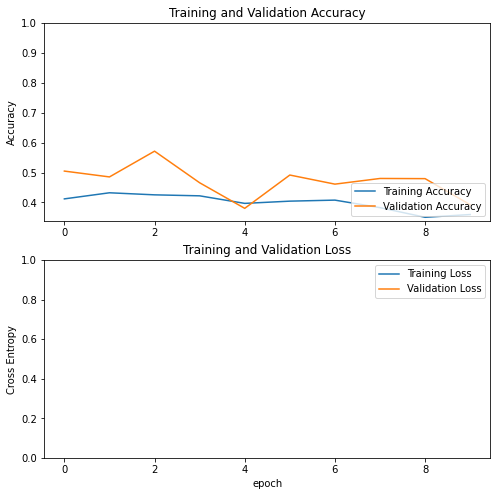

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir='/content/gdrive/MyDrive/content/img_dir/logs/vgg16/us8k/fit/'

In [ ]:
#Found 8716 files belonging to 10 classes.
#Using 6973 files for training.
#Found 8716 files belonging to 10 classes.
#Using 1743 files for validation